In [20]:
!pip3 install pyarrow

2693.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 3.1 MB/s eta 0:00:0000:0100:01


In [25]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as pltx
import seaborn as sns
import joblib

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [3]:
train_df = pd.read_csv("./train.csv")

test_df = pd.read_csv("./test.csv")

train_rest = train_df.drop(columns="Exited")
train_tragets = train_df["Exited"]

#stratify should ensure the same amount of y respresented for each dataset
train_data, val_data, train_y, val_y = train_test_split(train_rest,
                                                        train_tragets, 
                                                        test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=train_tragets
                                                        )

train_data_df = pd.concat([train_data, train_y], axis=1)
val_data_df = pd.concat([val_data, val_y], axis=1)

#not using the surname since it will provide more noise than usefull information
train_data_df = train_data_df.drop(columns=["Surname","CustomerId"])
val_data_df = val_data_df.drop(columns=["Surname","CustomerId"])

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [15]:
input_cols = list(train_data_df.columns)[1:-1]
target_col = 'Exited'

train_inputs, train_targets = train_data_df[input_cols], train_data_df[target_col]
val_inputs, val_targets = val_data_df[input_cols], val_data_df[target_col]

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [16]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

numeric_cols,categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember'],
 ['Geography', 'Gender'])

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [17]:
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

train_inputs = preprocessor.fit_transform(train_inputs)
val_inputs   = preprocessor.transform(val_inputs)

display(train_inputs[:5])
display(val_inputs[:5])

array([[0.59904535, 0.21428571, 0.1       , 0.62638244, 0.        ,
        1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.60381862, 0.375     , 0.2       , 0.84883607, 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        ],
       [0.65393795, 0.30357143, 0.6       , 0.55452244, 0.33333333,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        ],
       [0.56801909, 0.71428571, 0.        , 0.        , 0.33333333,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 1.        ],
       [0.65871122, 0.05357143, 0.3       , 0.        , 0.33333333,
        1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 1.        ]])

array([[0.67541766, 0.5       , 0.1       , 0.55187017, 1.        ,
        1.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 1.        ],
       [0.38663484, 0.41071429, 0.5       , 0.        , 0.33333333,
        1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.71599045, 0.35714286, 0.2       , 0.        , 0.33333333,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        1.        , 0.        ],
       [0.57756563, 0.44642857, 0.4       , 0.74244056, 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        1.        , 0.        ],
       [0.58949881, 0.21428571, 0.4       , 0.        , 0.33333333,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 0.        ]])

We don't need to fill the NaN cells, because we dont have any. I decided to use pretty simple pipeline, for numeric i only scale values, for categorical i use one hot encoder. Thats all

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [18]:
one_hot_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

all_names = numeric_cols + list(one_hot_names)

train_inputs = pd.DataFrame(train_inputs, columns=all_names)
val_inputs = pd.DataFrame(val_inputs, columns=all_names)
train_targets = pd.DataFrame(train_targets)
val_targets = pd.DataFrame(val_targets)

In [ ]:
train_inputs.to_parquet("./processed_data/train_inputs.parquet")
val_inputs.to_parquet("./processed_data/val_inputs.paraquet")
train_targets.to_parquet("./processed_data/train_targets.parquet")
val_targets.to_parquet("./processed_data/val_targets.parquet")

In [22]:
!ls ./processed_data

2744.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


train_inputs.parquet  val_inputs.paraquet
train_targets.parquet val_targets.parquet


6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [23]:
model = LogisticRegression(solver='liblinear')

x_train = train_inputs[all_names]
y_train = np.ravel(train_targets)
x_val = val_inputs[all_names]
y_val = np.ravel(val_targets)

model.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Accuracy: 87.43%
TN: 0.959719606612262
FP: 0.04028039338773802
FN: 0.45986895986895987
TP: 0.5401310401310402
Recall is: 0.5401310401310402
Precission is: 0.9306002758361671
F1 score : 0.64%
AUROC for : 0.88


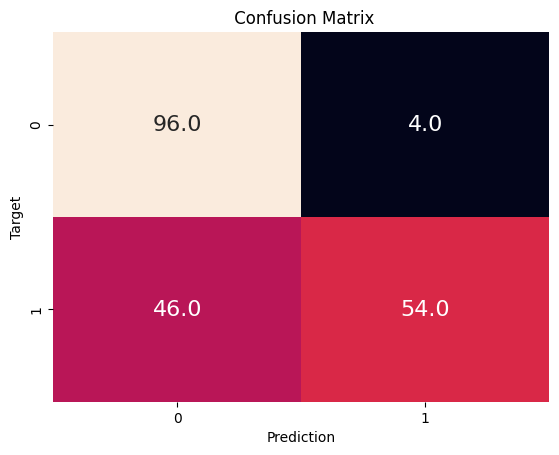

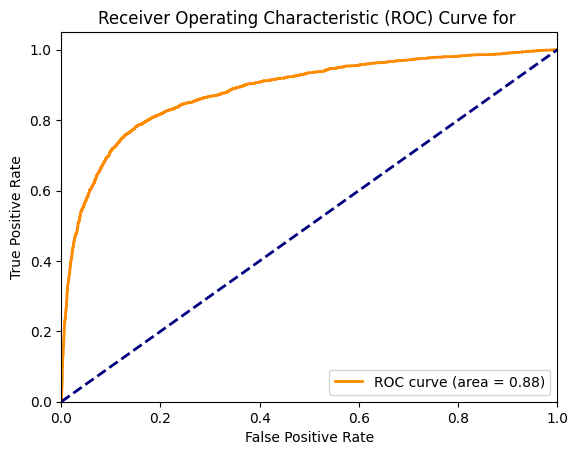

Accuracy: 87.10%
TN: 0.9493723849372385
FP: 0.050627615062761505
FN: 0.4360655737704918
TP: 0.5639344262295082
Recall is: 0.5639344262295082
Precission is: 0.9176200095985357
F1 score : 0.64%
AUROC for : 0.88


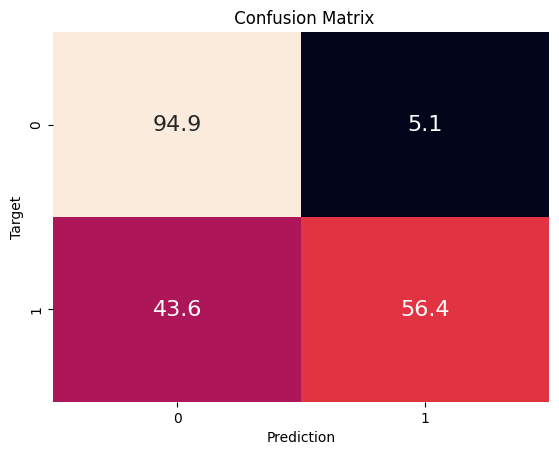

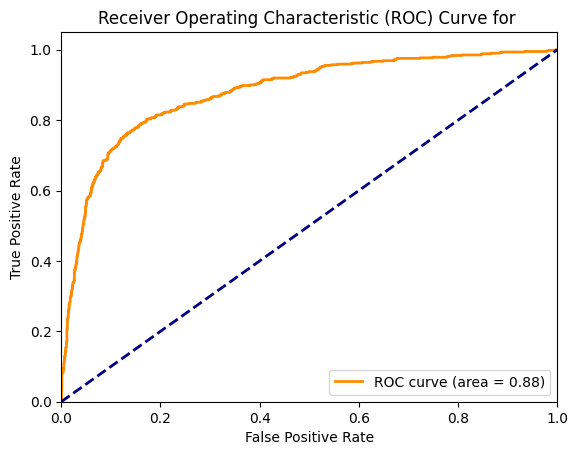

In [27]:
# pred_train = model.predict(x_train)

def predict_and_plot(inputs, targets, model, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    [TN, FP], [FN, TP] = cf
    
    print("TN:", TN)
    print("FP:", FP)
    print("FN:", FN)
    print("TP:", TP)
    
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    print("Recall is:", recall)
    print("Precission is:", precision)
    
    plt.figure()
    sns.heatmap(cf, annot=cf*100 ,fmt=".1f", annot_kws={"size": 16}, cbar=False)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

def get_f1_score(inputs, targets, model, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds)
  print(f"F1 score {name}: {f1_score_:.2f}%")

def compute_auroc_and_build_roc(inputs, targets, model, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

predict_and_plot(x_train, y_train, model)
get_f1_score(x_train, y_train, model)
compute_auroc_and_build_roc(x_train, y_train, model)

predict_and_plot(x_val, y_val, model)
get_f1_score(x_val, y_val, model)
compute_auroc_and_build_roc(x_val, y_val, model)

I would say this model is not so bad even with not much tuning, but based on observations we can clearly see that it is a bit biased towards majority

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

Accuracy: 87.43%
TN: 0.5401310401310402
FP: 0.45986895986895987
FN: 0.04028039338773802
TP: 0.959719606612262
Recall is: 0.959719606612262
Precission is: 0.6760547592963141
F1 score : 0.92%
AUROC for : 0.88


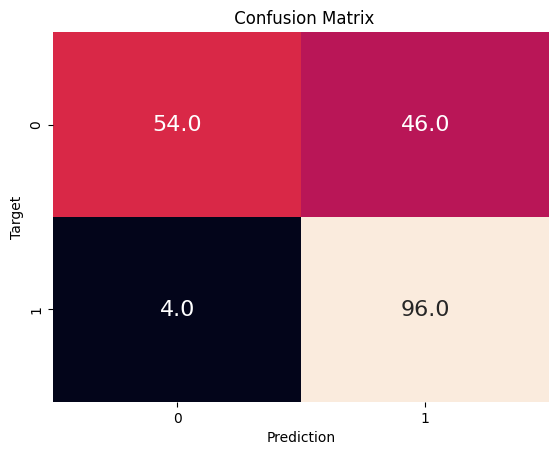

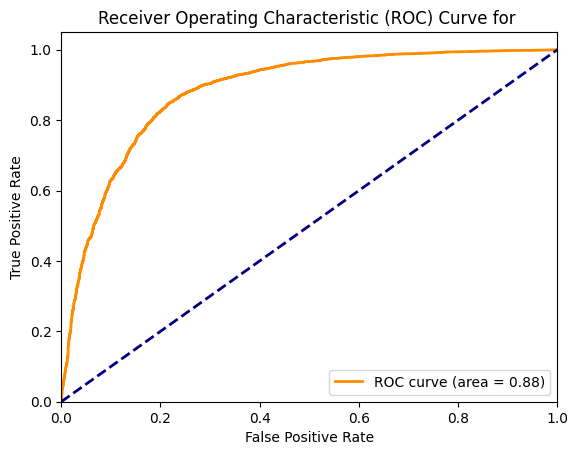

Accuracy: 87.10%
TN: 0.5639344262295082
FP: 0.4360655737704918
FN: 0.050627615062761505
TP: 0.9493723849372385
Recall is: 0.9493723849372385
Precission is: 0.6852507389235728
F1 score : 0.92%
AUROC for : 0.88


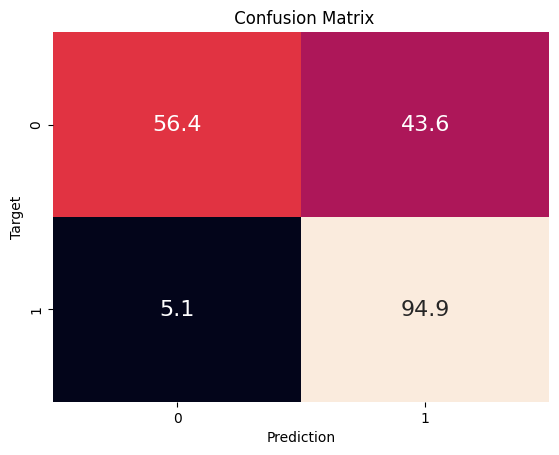

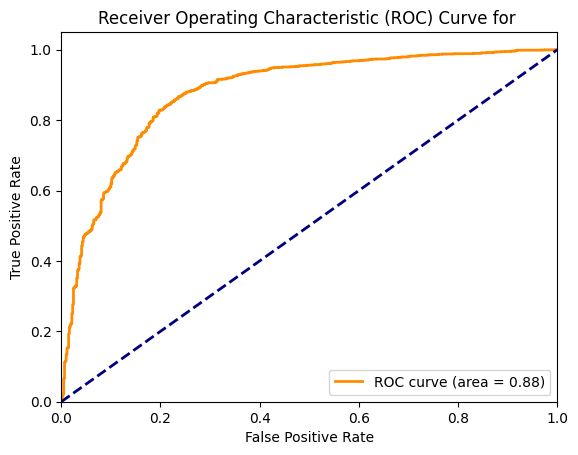

In [28]:
new_model = LogisticRegression(solver='liblinear')

y_train_rev = np.ravel(1 - train_targets)
y_val_rev = np.ravel(1 - val_targets)

new_model.fit(x_train, y_train_rev)

predict_and_plot(x_train, y_train_rev, new_model)
get_f1_score(x_train, y_train_rev, new_model)
compute_auroc_and_build_roc(x_train, y_train_rev, new_model)

predict_and_plot(x_val, y_val_rev, new_model)
get_f1_score(x_val, y_val_rev, new_model)
compute_auroc_and_build_roc(x_val, y_val_rev, new_model)

This model is much better on predicting majority class.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [29]:
bank_predictor = {
    'model': model,
    'numeric_transformer': numeric_transformer,
    'categorical_transformer': categorical_transformer,
    'preprocessor': preprocessor,
    'numeric_cols': numeric_cols,
    'one_hot_names': list(one_hot_names),
}

joblib.dump(bank_predictor, 'bank_predictor.joblib')

['bank_predictor.joblib']

Accuracy: 87.43%
TN: 0.959719606612262
FP: 0.04028039338773802
FN: 0.45986895986895987
TP: 0.5401310401310402
Recall is: 0.5401310401310402
Precission is: 0.9306002758361671
F1 score : 0.64%
AUROC for : 0.88


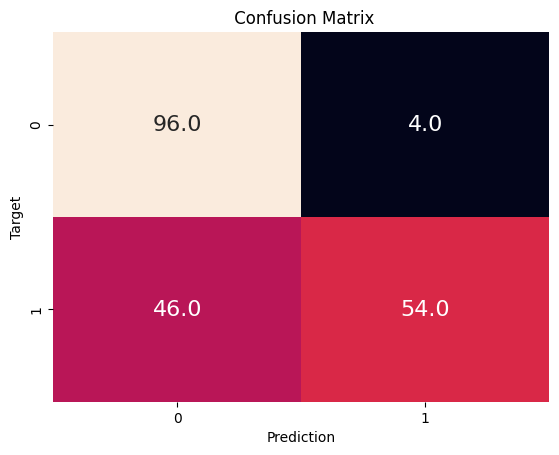

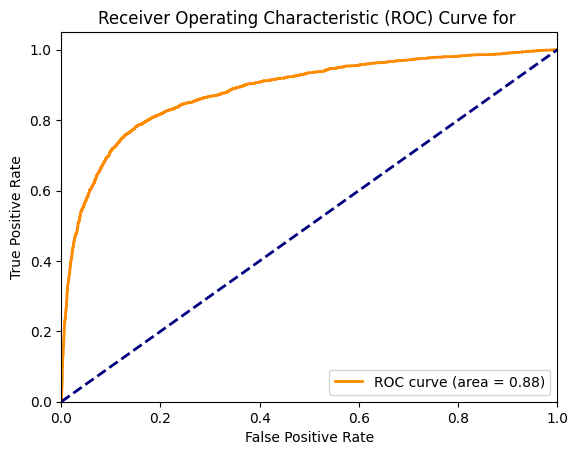

In [30]:
model_2 = joblib.load('bank_predictor.joblib')

predict_and_plot(x_train, y_train, model_2["model"])
get_f1_score(x_train, y_train, model_2["model"])
compute_auroc_and_build_roc(x_train, y_train, model_2["model"])

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [47]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(preprocessor, model, input_df: pd.DataFrame, test_df):
    input_df = input_df.drop(columns=["Surname","CustomerId"])
    test_df = test_df.drop(columns=["Surname","CustomerId"])
    input_df = preprocessor.transform(input_df)
    test_df = preprocessor.transform(test_df)
    X_input = input_df
    prob_test = model.predict_proba(test_df)[:,1]
    # prob_train = model.predict_proba(X_input)[:,1]
    return prob_test

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [48]:
test_raw_df = test_df

test_prob = predict_raw_df(model_2['preprocessor'],model_2["model"], train_data, test_raw_df)

test_raw_df["Exited"] = test_prob


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [54]:
sample_submition = pd.read_csv('./sample_submission.csv')

sample_submition["Exited"] = test_raw_df["Exited"]

sample_submition.to_csv("./submission_log_reg.csv", index=False)
